# Section 5 : Extracting a region from mesh-based data

This process is considerably more involved than with "structured" data like UM.

For instance, UM data has data and coordinates with X and Y dimensions, corresponding to cell indices in the model arrays, and longitudes and latitudes of cells on the globe.  
Therefore, we can slice out a rectangular range of X and Y indices, e.g. `my_datacube[..., 10:40, 4:77]` and the result is some contiguous region of the globe within a defined range of latitude+longitude.

However, the unstructured mesh does not visit locations on the globe in any particular, simple regular pattern.  So crucially, a slice of data from the (now 1-D) arrays is not a contiguous geographical region.  And conversely a contiguous region of the data is generally not contained in a contiguous range of data indices.  
( *TODO: picture of this ?* )

So we must use geographical calculations to extract mesh data within a required region.  
Since this is a geographical concept, Geovista provides support for it.  
This is also a good match since, with larger data this can become quite compute-intensive :
Processing via VTK should be performant and scalable, and can benefit from GPU accelaration.

Here's an example of how to extract the mesh falling within a defined lat-lon region ...  
**NOTE: as with the plotting example, there are no Iris utility functions for this, so a fair amount of user code is currently required to mediate between the Iris and Geovista/PyVista worlds.**

---

**First, import the utility function `lfric_rh_datacube` from `testdata_fetching`, and call it to get a global LFRic test cube.**

In [1]:
from testdata_fetching import lfric_rh_singletime_2d
lfric_rh = lfric_rh_singletime_2d()
lfric_rh

Relative Humidity At Screen Level (1),--
Shape,221184
Mesh coordinates,
latitude,x
longitude,x
Mesh,
name,Topology data of 2D unstructured mesh
location,face
Scalar coordinates,
forecast_period,21600 seconds
forecast_reference_time,2021-03-24 00:00:00


**Create a Polydata object from this.**  
Use the routine `pv_from_lfric_cube` from the package `pv_conversions`, which we used in the plotting section.

In [2]:
from pv_conversions import pv_from_lfric_cube
pv_global_rh = pv_from_lfric_cube(lfric_rh)

---

Now we will create a tool to extract over a desired region.

**Import the class `BBox` from `geovista.geodesic`, and make one...**  

In [3]:
from geovista.geodesic import BBox

Note: the name here is short for "Bounding Box".

**Use the notebook "?" command to display the function signature of its constructor : `?BBox.__init__`**

In [4]:
?BBox.__init__

Signature:
BBox.__init__(
    self,
    lons: Union[numpy.__array_like._SupportsArray[numpy.dtype], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    lats: Union[numpy.__array_like._SupportsArray[numpy.dtype], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    ellps: Optional[str] = 'WGS84',
    c: Optional[int] = 256,
    triangulate: Optional[bool] = False,
)
Docstring:
Create a 3D geodesic bounding-box for extracting an enclosed surface, lines
or points.

The bounding-box region is specified in terms of its four corners, in
degrees of longitude and latitude. As the bounding-box is a geodesic, it
can only ever at most enclose half of an ellipsoid.

Th

---

**Create a BBox to specify a bounding rectangle in lat-lon space.**  
Give it `lons` and `lats` arguments which specify the points of a bounding rectangle,
in lat-lon space, from 0..70 in longitude and -24..+45 in latitude.  
( *Note:* do ***not*** supply a duplicate 'end' point -- a closed loop is automatically generated. )

In [5]:
bbox = BBox(lons=[0, 70, 70, 0], lats=[-25, -25, 45, 45])

---

**Now "apply" the BBox to the global mesh data, by passing it to the `BBox.enclosed` method.**  
And show the resulting object printout.

In [6]:
# 'Apply' the region to the PolyData object.
pv_regional_rh = bbox.enclosed(pv_global_rh)
pv_regional_rh

PolyData (0x7fe458b65dc0)
  N Cells:	27029
  N Points:	27380
  N Strips:	0
  X Bounds:	2.370e-01, 1.000e+00
  Y Bounds:	-8.181e-03, 9.415e-01
  Z Bounds:	-5.033e-01, 7.787e-01
  N Arrays:	5

You can see that this new (regional) PolyData has fewer cells than the original (global) one.

---
**Now plot this to see what it looks like.**  
Note : in this case, it will be very useful to add coastlines for reference.
Use the techniques from [Sec#2 Plotting - Additional features](./Sec_03_Plotting.ipynb#Additional-features).

In [7]:
from geovista import GeoPlotter
plotter = GeoPlotter()
plotter.add_mesh(pv_regional_rh)
plotter.add_coastlines()
plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

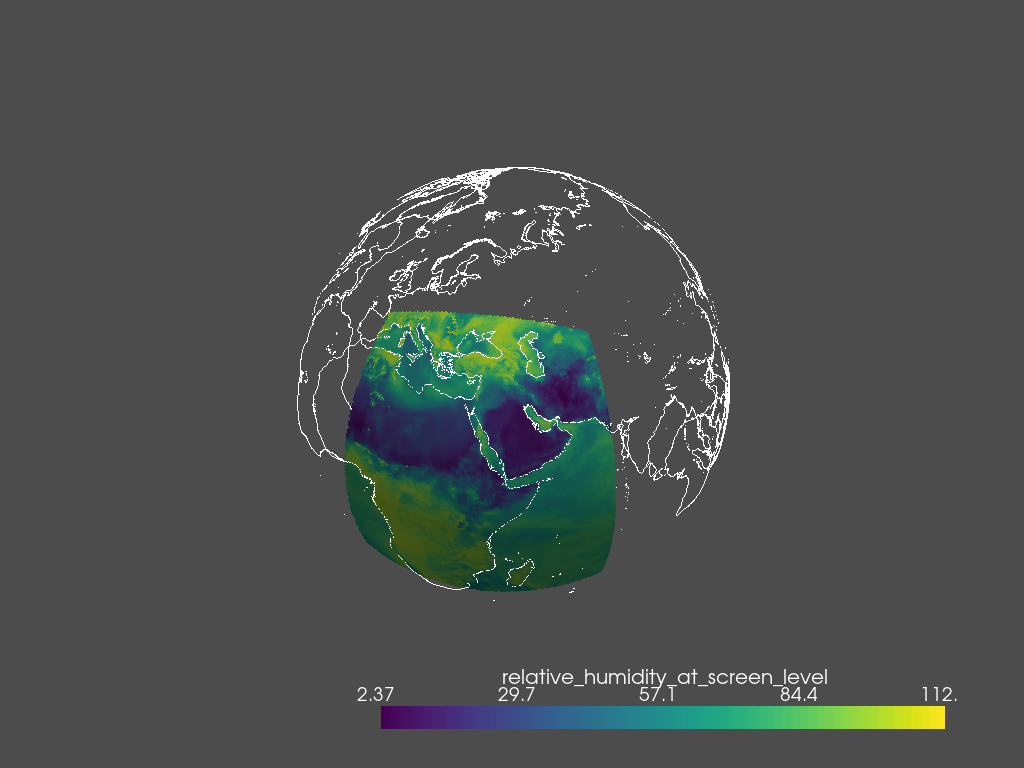

In [8]:
# Additional : static plot for notebook review
plotter.show(jupyter_backend='static')

---
## Get an Iris cube for an extracted region.

While GeoVista provides the efficient tools for mesh region extraction, it and Iris know nothing about one another.  
So, to calculate a regionally-extracted _Iris cube_, GeoVista can do the hard work of determining the subset of cells required, but you must then "reconstruct" an Iris cube from that information.

For now, at least, there are no ready-made tools for this (in either Iris or Geovista).  

However, the operation is possible, and may be instructive.  
So, for those interested, there is an extra notebook ["MeshCube_Extraction.ipynb"](./MeshCube_Extraction.ipynb), showing how this is done.


